In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [3]:
data_transforms = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomVerticalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'eval': transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
}    # 应该先Resize还是先CenterCrop? RandomRation效果怎么样,是否需要Padding?

data_dir = './data'
img_datasets = {x: datasets.ImageFolder(os.path.join(
    data_dir, x), data_transforms['train' if x == 'train' else 'eval']) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(img_datasets[x], batch_size=10, shuffle=True, num_workers=16)
               for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(img_datasets[x]) for x in ['train', 'val', 'test']}
class_name = img_datasets['train'].classes


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [4]:
import json

print(class_name)
with open('./data/class_name.json','w') as f:
    json.dump(class_name,f)

['flower', 'fruit']


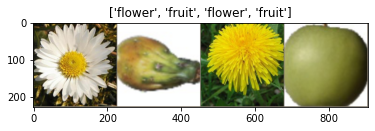

In [5]:
def imshow(inp: torch.Tensor, title=None):
    '''Tensor图片显示'''
    inp = inp.numpy().transpose((1, 2, 0))    # 使用ToTensor之后会将原本图片的H,W,C转变为C,H,W
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)    # 将值限制在[0,1]之间

    plt.imshow(inp)
    if title:
        plt.title(title)

    plt.pause(0.001)    # 等待一段时间使plots 更新
    
    
inputs,classes = next(iter(dataloaders['val']))    # 获取一个batch的数据

out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_name[x] for x in classes[:4]])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_para = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch %5d/%5d ' % (epoch + 1, num_epochs))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_correct = 0

            for inputs, lebals in dataloaders[phase]:
                inputs = inputs.to(device)
                lebals = lebals.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #print('model excuted.')
                    loss = criterion(outputs, lebals)
                    #print('loss excuted.')

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)     # 将平均值乘以个数
                # .data什么意思?
                running_correct += torch.sum(preds == lebals.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_correct.double() / dataset_sizes[phase]

            print('%s    Loss:%.4f    Acc:%.4f' %
                  (phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > (best_acc):
                best_acc = epoch_acc
                best_model_para = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training Complete in %dm %ds' %
          (time_elapsed//60, time_elapsed % 60))
    print('Best val Acc:%4f' % (best_acc))

    model.load_state_dict(best_model_para)
    return model

In [7]:
def visualize_model(model, num_img=6):
    is_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_img//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(class_name[preds[j]])
                imshow(inputs.cpu().data[j])

                if images_so_far == num_img:
                    model.train(mode=is_training)
                    return
        model.train(mode=is_training)

In [8]:
net = models.resnet50(pretrained=True)
num_ftrs = net.fc.in_features

net.fc = nn.Linear(num_ftrs,2)

#print(net(torch.randn((2,3,244,244))).size())
net = net.to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
net_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [ ]:
net = train_model(net,criterion,optimizer,net_lr_scheduler,num_epochs=200)

Epoch     1/  200 


In [ ]:
visualize_model(net)

In [ ]:
torch.save(net,'./ResNet50.model')